### Solución Desafío - Naive Bayes

* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.

### Descripción

* En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. 
* Cada uno de los csv se encuentra en la carpeta dump dentro del proyecto. Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
* En base a esta información, se les pide un modelo generativo que pueda predecir el género de una canción a patir de la letra de una canción.
* Existen 4 géneros que se registran en la base de datos, por lo que para esta actividad trabajaremos con un Multinomial Naive Bayes.

### Ejercicio 1: Preparar el ambiente de trabajo

* Importe los módulos numpy , pandas , matplotlib , seaborn , glob y os siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump.
* Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
* Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings

warnings.filterwarnings(action='ignore')

In [2]:
dfs = list(map(lambda path: pd.read_csv(os.getcwd() + '/' + path), glob.glob('files/dump/*')))
df = pd.concat(dfs).drop(columns=['Unnamed: 0'])
df.columns = ['artist', 'genre', 'song', 'lyrics']
df.head()

,artist,genre,song,lyrics
0,The Beatles,rock,I Saw Her Standing There,"One, two, three, four! \n Well, she was just s..."
1,The Beatles,rock,Misery,The world is treating me bad \n Misery \n I'm ...
2,The Beatles,rock,Anna (Go To Him),"Anna \n You come and ask me, girl \n To set yo..."
3,The Beatles,rock,Chains,Chains \n My baby's got me locked up in chains...
4,The Beatles,rock,Boys,I've been told when a boy kiss a girl \n Take ...


### Ejercicio 2: Descripción de los datos
* Utilizando el objeto creado en el Ejercicio 1, genere dos gráficos de barras que resuman la siguiente información:
    * La cantidad de canciones registradas por cada artista, ordenado de mayor a menor.
    * La cantidad de canciones registradas en cada género, ordenados de mayor a menor.
* Comente sobre las principales tendencias.

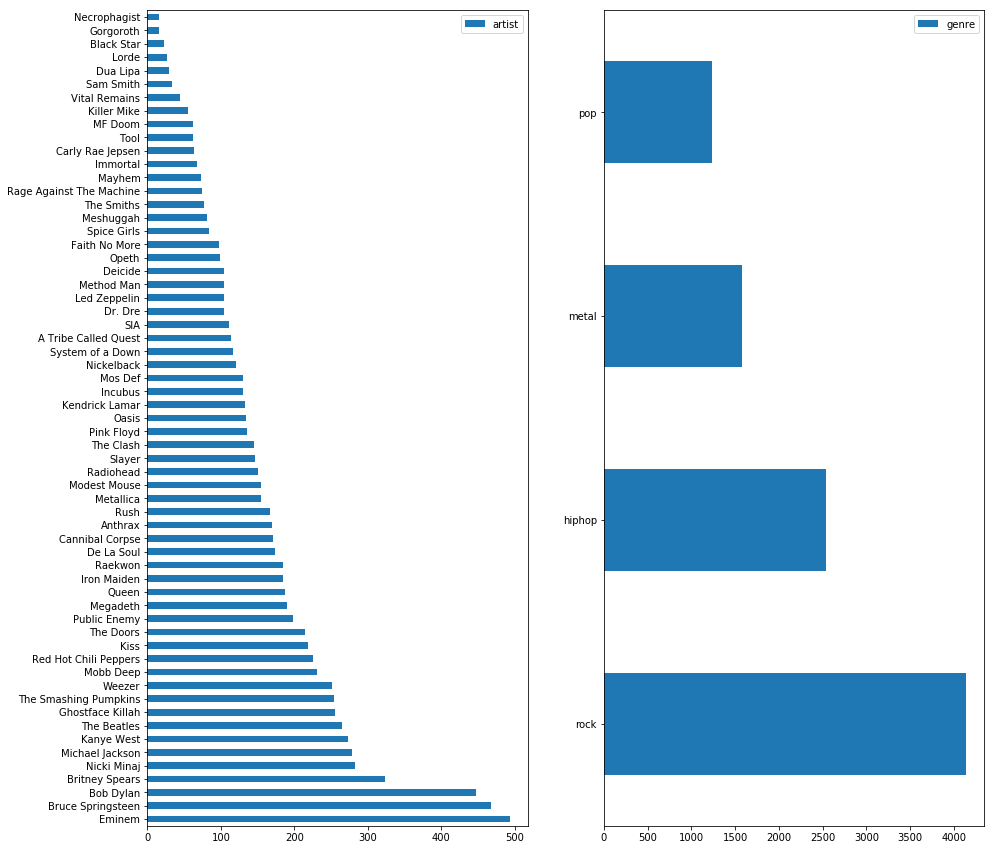

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(15,15))
df['artist'].value_counts(ascending=False).to_frame().plot.barh(ax=ax[0])
df['genre'].value_counts(ascending=False).to_frame().plot.barh(ax=ax[1]);

- Existen muchas canciones clasificadas como rock y como hiphop. Pop está subrepresentada.
- Hay algunos artistas con muchos datos, como por ejemplo Britney Spears, Bob Dylan, Bruce Springsteen y Eminem.

### Ejercicio 3: Matriz de ocurrencias

* Digresión: Tokenización de Textos
    * Para poder trabajar con textos, debemos pasarlos a una matriz dispersa, donde cada fila representará una entrada (en este caso, una canción), y cada columna representará una palabra (token). Este es el proceso de tokenización: Identificar la ocurrencia de una palabra específica dentro de un conjunto de textos (corpus). El tokenizador más simple sklearn.feature_extraction.text.CountVectorizer genera una colección de textos a una matriz que representa la frecuencia dentro del texto de una palabra específica. El tokenizador funciona de la siguiente manera:
    
```python

from sklearn.feature_extraction.text import CountVectorizer
# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words='english')
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(lista_de_textos)
# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)
```
    
    
* Importe la clase CountVectorizer dentro de los módulos feature_extraction.text de la librería sklearn . Lea la documentación asociada a ésta. ¿Cuál es el objetivo de esta clase?
* Aplique la clase para extraer las 100 palabras más repetidas en toda la base de datos.
* Genere una función que replique el procedimiento para cada uno de los géneros.
* Comente sobre las principales características de cada género en cuanto a sus palabras.

La clase `CountVectorizer` convierte una colección de textos a una matriz de conteo de cada palabra en los textos.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def most_common_words(df):
    count_vectorizer = CountVectorizer(stop_words='english')
    lyrics_count = count_vectorizer.fit_transform(df['lyrics'])
    words = count_vectorizer.get_feature_names()
    words_freq = lyrics_count.toarray().sum(axis=0)
    return pd.DataFrame({ 'freq': words_freq }, index=words).sort_values(by='freq', ascending=False)[:100]

In [5]:
most_common = most_common_words(df)
most_common

,freq
like,19629
don,17398
know,14962
got,14171
just,13978
love,11268
yeah,11071
ll,10028
oh,9879
cause,8356


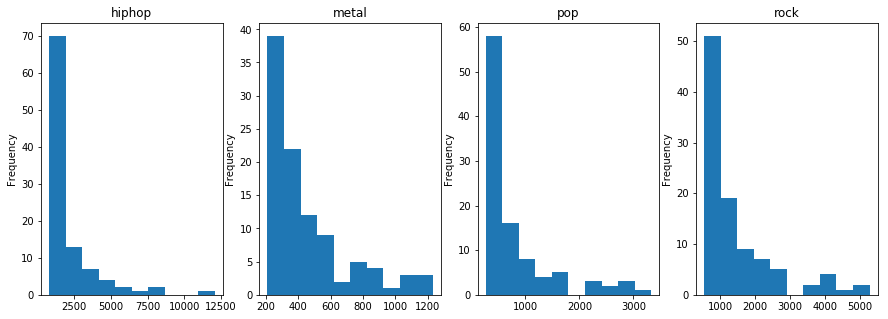

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(15,5))
n = 0

for name, group in df.groupby(by='genre'):
    most_common_words(group)['freq'].plot.hist(ax=ax[n])
    ax[n].set_title(name)
    n += 1

Podemos ver que existen algunas palabras que con una frecuencia muy alta para cada sub género.

### Ejercicio 4: Entrenamiento del Modelo
* Digresión: sklearn Pipelines
    * La clase Pipeline del módulo sklearn.pipeline permite concatenar múltiples pasos de procesamiento y preprocesamiento en un estimador generado por algún método de scikitlearn . En sí, la clase cuenta con los métodos clásicos fit , predict y score y presenta un comportamiento idéntico a los demás objetos de scikit-learn . Uno de los usos más comunes es para concatenar pasos de preprocesamiento con un modelo.
    
* Componentes de un Pipeline
   * Imaginemos que deseamos implementar el siguiente modelo. Considerando un conjunto de datos, deseo Estandarlizarlo, posteriormente extraer sus principales componentes y finalmente aplicar un modelo de regresión lineal. Este flujo se puede reexpresar como:
       
```python
pipeline_model = Pipeline([('scale', StandardScaler()),
                            ('pca', RandomizedPCA(n_components=3)),
                            ('model', LinearRegression())])
```
Algunos de los elementos a considerar:
1. Cada paso se considera como una tupla, donde se declara el nombre del paso y la función
a implementar. En este caso, nuestro primer paso es estandarizar la matriz, por lo que
asociamos el método StandardScaler con el string scale .
2. Todos los pasos declarados se incorporan en una lista, donde el orden de ingreso
representa el orden de ejecución.
Posteriormente el objeto creado puede utilizarse con los siguientes métodos

```python
pipeline_model.fit(X_train, y_train)
y_hat = pipeline_model.predict(y_test)
```

* Importe MultinomialNB , train_test_split , Pipeline , confusion_matrix y classification_report.
* Genere las muestras de entrenamiento y validación reservando un 40% para validación y declarando una semilla pseudoaleatoria.
* Monte el modelo dentro de un Pipeline , donde el primer paso es implementar CountVectorizer y el segundo sea ejecutar el clasificador MultinomialNB.
* A continuación se les presenta una lista de letras, ¿cuáles serían las predicciones correspondientes?

```python
['I got a place in the underworld', # Brody Dalle - Underworld
'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
"Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris -Move B*tch
'Sexual violence doesn’t start and end with rape It starts in our books and behind our school gates' # IDLES - Mother,
"Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting You are not deserving, you are not deserving" #Banks -Drowning
]
```

* Genere una predicción implementando la muestra de validación y contraste las predicciones del modelo con las etiquetas verdaderas. Reporte las principales métricas.

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [8]:
y = df['genre']
X = df['lyrics']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.4, random_state = 5082019)

pipeline_model = Pipeline([('counter', CountVectorizer(stop_words='english')),
                            ('model', MultinomialNB())])

pipeline_model.fit(X_train, y_train);

Predicciones solicitadas:

In [9]:
to_predict = ['I got a place in the underworld', # Brody Dalle - Underworld
'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
"Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris -Move B*tch
'Sexual violence doesn’t start and end with rape It starts in our books and behind our school gates' # IDLES - Mother,
"Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting You are not deserving, you are not deserving" #Banks -Drowning
]

print('Las predicciones solicitadas, respectivamente, son:', ', '.join(pipeline_model.predict(to_predict)))

Las predicciones solicitadas, respectivamente, son: rock, metal, rock, pop, rock


Ahora para el conjunto de test:

In [10]:
y_hat = pipeline_model.predict(X_test)

In [11]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

      hiphop       0.83      0.93      0.88       991
       metal       0.83      0.68      0.75       662
         pop       0.67      0.39      0.49       479
        rock       0.77      0.86      0.81      1664

    accuracy                           0.79      3796
   macro avg       0.77      0.72      0.73      3796
weighted avg       0.78      0.79      0.78      3796



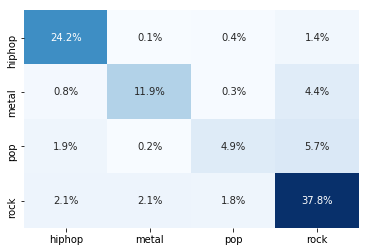

In [12]:
cnf = confusion_matrix(y_test, y_hat) / len(y_test)
sns.heatmap(cnf, xticklabels=pipeline_model.classes_, yticklabels=pipeline_model.classes_, annot=True, fmt=".1%", cbar=False, cmap='Blues');

#### Observaciones

- Este modelo clasifica de forma correcta casi el 80% de los casos.
- En el caso de pop, el modelo al tener alto precision y bajo recall, significa que hay muchas canciones que son pop que no reconoce. Notar que esta clase está subrepresentada, tiene muy pocas observaciones comparada con el resto.

### Ejercicio 5: Mejora del Modelo

* Proponga una estrategia para mejorar el desempeño del modelo en la categoría con peores métricas.
* Repita los pasos de entrenamiento y reporte de métricas, esta vez incluyendo los nuevos datos suministrados.
* Comente sobre el desempeño general de éste.

Una estrategia que podemos usar es recolectar más datos de las caterogorías con peores métricas, ya que justamente estas son las que están poco presentes en las observaciones.

              precision    recall  f1-score   support

      hiphop       0.89      0.93      0.91      1988
       metal       0.85      0.79      0.82      1294
         pop       0.74      0.66      0.70      1521
        rock       0.81      0.84      0.83      3315

    accuracy                           0.82      8118
   macro avg       0.82      0.81      0.81      8118
weighted avg       0.82      0.82      0.82      8118



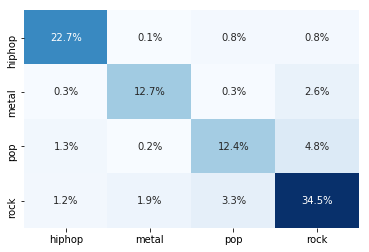

In [13]:
dfs = list(map(lambda path: pd.read_csv(os.getcwd() + '/' + path), glob.glob('files/**/*')))
df = pd.concat(dfs).drop(columns=['Unnamed: 0'])
df.columns = ['artist', 'genre', 'song', 'lyrics']

y = df['genre']
X = df['lyrics']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.4, random_state = 5082019)

pipeline_model = Pipeline([('counter', CountVectorizer(stop_words='english')),
                            ('model', MultinomialNB())])

pipeline_model.fit(X_train, y_train)
y_hat = pipeline_model.predict(X_test)

print(classification_report(y_test, y_hat))

cnf = confusion_matrix(y_test, y_hat) / len(y_test)
sns.heatmap(cnf, xticklabels=pipeline_model.classes_, yticklabels=pipeline_model.classes_, annot=True, fmt=".1%", cbar=False, cmap='Blues');

#### Observaciones

- Viendo la matriz de confusión, podemos ver que el modelo mejoró un poco (de 79% a 82%)
- Pop mejoró mucho, pues pasó de tener un `f1 score` de 0.49 a 0.7 (recall pasó de 0.39 a 0.66 y precision de 0.67 a  0.74
- Mejoró el `f1 score` de todas las categorías, así como también `precision` y `recall`, excetuando el `recall` en la categoría `rock` donde disminuyó un poco (de 0.86 a 0.84).